# Imitation Learning: Learning from Demonstrations


In Reinforcement Learning (RL), we often rely on a well-defined reward function to guide our agent's
learning process. However, designing a good reward function can be a significant challenge in many
real-world scenarios. Think about teaching a robot to perform a complex acrobatic maneuver.
Specifying the reward for every small movement and interaction would be incredibly difficult!

Imitation Learning offers a different approach. Instead of learning from a reward signal, an IL
agent learns by **imitating an expert**. We provide the agent with demonstrations of the desired
behavior, and the agent's goal is to learn a policy that reproduces this behavior.

In this notebook, we'll explore the fundamentals of Imitation Learning, starting with the most
intuitive and straightforward method: **Behavioral Cloning (BC)** 🤖.


## Behavioral Cloning (BC)

**Behavioral Cloning** is the simplest form of Imitation Learning. The core idea is to treat IL as a
supervised learning problem. We have a dataset of expert demonstrations, which consists of
state-action pairs `(s, a)`. The state `s` is what the expert observed, and the action `a` is what
the expert did in that state.

Our goal is to train a policy `π(s)` that takes a state `s` as input and outputs an action `a` that
is as close as possible to the expert's action. This can be a classification problem for discrete
actions or a regression problem for continuous actions.

Beyond being a standalone method, BC is a crucial component in more complex systems. For instance,
in algorithms like **AlphaZero**, an initial policy is trained via BC on a dataset of human expert
games. This provides the agent with a strong, sensible starting point, allowing it to
**"kickstart"** its learning process and explore more intelligently than if it started from a
completely random policy.


In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random

from util.gymnastics import gym_simulation, init_random
from util.rl_algos import AgentSAC

### 1. Setup and Environment

First, let's import the necessary libraries. We'll be using `gymnasium` and `mujoco` for the
environment.


In [2]:
env = gym.make("Swimmer-v5")
env = init_random(env)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(f"Environment: Swimmer-v5")
print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")

Environment: Swimmer-v5
State dimension: 8
Action dimension: 2


### 2. Loading the Expert and Visualizing its Performance

Instead of creating a toy expert, we will load a real, pre-trained SAC agent. This gives us a
high-quality source of demonstrations.


In [3]:
expert_agent = AgentSAC(state_dim, action_dim)
expert_agent.load("solution/swimmer_v5_sac_weights.pth")
print("Expert agent loaded successfully.")

Expert agent loaded successfully.


Let's see how our expert performs! The cell below will render the environment and show the expert
agent in action.


/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


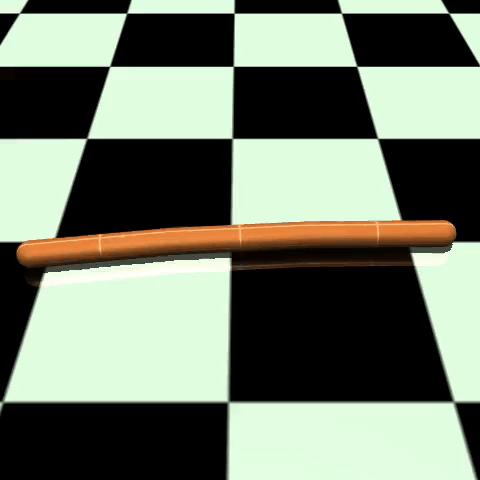

In [4]:
# Visualize the expert's behavior
gym_simulation("Swimmer-v5", expert_agent, max_t=150)

### 3. Generating Expert Demonstrations

Now, we'll run the expert policy in the environment to collect a dataset of `(state, action)` pairs.
This dataset will be the ground truth for training our behavioral cloning agent.


In [5]:
def generate_expert_data(env, policy, num_episodes=100):
    states = []
    actions = []

    for _ in tqdm(range(num_episodes), desc="Generating Expert Data"):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy.act(state)
            states.append(state)
            actions.append(action)

            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    return np.array(states), np.array(actions)

In [6]:
expert_states, expert_actions = generate_expert_data(env, expert_agent)
print(f"Generated {len(expert_states)} state-action pairs.")

Generating Expert Data:   0%|          | 0/100 [00:00<?, ?it/s]

Generated 100000 state-action pairs.


### 4. The Behavioral Cloning Agent

Our BC agent will be a simple neural network that takes a state and predicts a continuous action
vector. Since this is a regression problem, we'll use Mean Squared Error (MSE) as our loss function.


In [7]:
class BCAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BCAgent, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh(),
        )

    def forward(self, state: torch.Tensor):
        return self.network(state)

    @torch.no_grad
    def act(self, state: np.array) -> np.array:
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.network(state)
        return action.squeeze(0).numpy()

### 5. Training the Agent

Now we train our `BCAgent` on the expert data. This is a standard supervised learning training loop
for regression.


In [8]:
bc_agent = BCAgent(state_dim, action_dim)

# Convert data to PyTorch Tensors
expert_states_tensor = torch.tensor(expert_states, dtype=torch.float32)
expert_actions_tensor = torch.tensor(expert_actions, dtype=torch.float32)

# Create a DataLoader
dataset = TensorDataset(expert_states_tensor, expert_actions_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Training setup
optimizer = optim.Adam(bc_agent.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 25
print("Training BC Agent...")
for epoch in range(num_epochs):
    total_loss = 0
    for states, actions in dataloader:
        optimizer.zero_grad()
        predicted_actions = bc_agent(states)
        loss = loss_fn(predicted_actions, actions)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

Training BC Agent...
Epoch 5/25, Average Loss: 0.033250
Epoch 10/25, Average Loss: 0.032516
Epoch 15/25, Average Loss: 0.032082
Epoch 20/25, Average Loss: 0.032148
Epoch 25/25, Average Loss: 0.031812


### 6. Evaluating and Comparing Policies

Now for the moment of truth! Let's see how our trained BC agent performs and compare it directly
with the expert. We will evaluate each policy over many episodes to get a stable estimate of their
performance.


In [9]:
def evaluate_policy(env, policy, num_episodes=50):
    total_rewards = []
    for _ in tqdm(range(num_episodes), desc=f"Evaluating {policy.__class__.__name__}"):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = policy.act(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_rewards.append(episode_reward)

    return total_rewards

In [10]:
# Evaluate both policies
expert_rewards = evaluate_policy(env, expert_agent)
bc_rewards = evaluate_policy(env, bc_agent)

# Calculate statistics
expert_mean, expert_std = np.mean(expert_rewards), np.std(expert_rewards)
bc_mean, bc_std = np.mean(bc_rewards), np.std(bc_rewards)

print(f"Expert Performance: {expert_mean:.2f} +/- {expert_std:.2f}")
print(f"BC Agent Performance: {bc_mean:.2f} +/- {bc_std:.2f}")

Evaluating AgentSAC:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating BCAgent:   0%|          | 0/50 [00:00<?, ?it/s]

Expert Performance: 325.85 +/- 3.04
BC Agent Performance: 327.00 +/- 1.38


### Performance Visualization

A picture is worth a thousand numbers. Let's plot the results to visually compare the two policies.


/tmp/ipykernel_344364/1898801080.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["Expert", "BC Agent"])


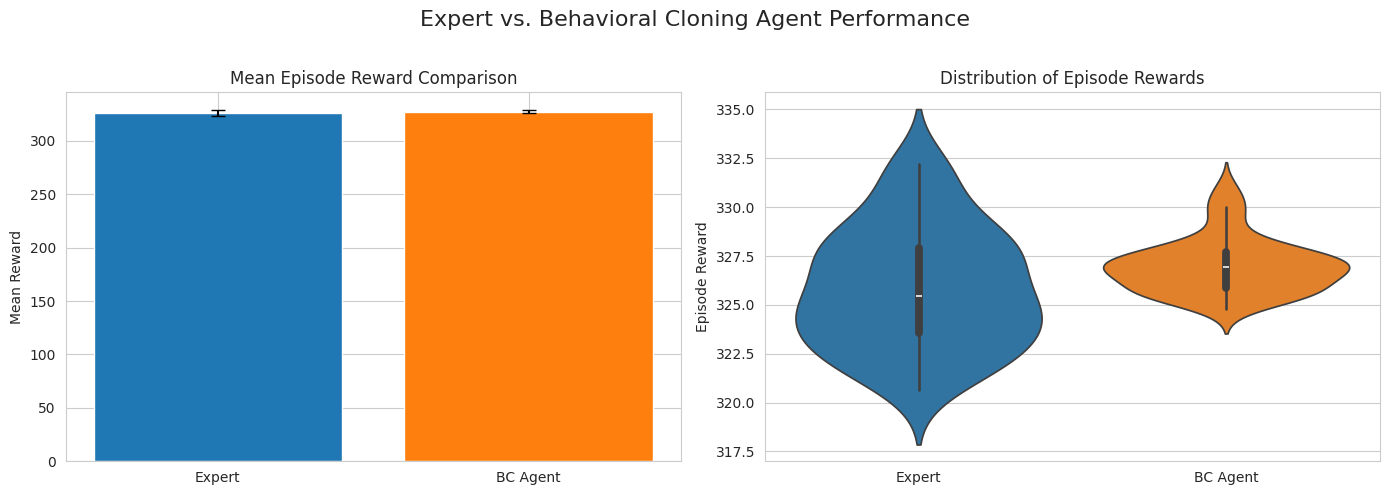

In [11]:
# Set a nice style for the plots
sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for mean comparison
axs[0].bar(
    ["Expert", "BC Agent"],
    [expert_mean, bc_mean],
    yerr=[expert_std, bc_std],
    capsize=5,
    color=["#1f77b4", "#ff7f0e"],
)
axs[0].set_title("Mean Episode Reward Comparison")
axs[0].set_ylabel("Mean Reward")

# Violin plot for distribution comparison
sns.violinplot(data=[expert_rewards, bc_rewards], ax=axs[1], palette=["#1f77b4", "#ff7f0e"])
axs[1].set_xticklabels(["Expert", "BC Agent"])
axs[1].set_title("Distribution of Episode Rewards")
axs[1].set_ylabel("Episode Reward")

plt.suptitle("Expert vs. Behavioral Cloning Agent Performance", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

You should see that the BC agent achieves performance that is close to the expert, but likely not
identical. This gap is the classic result of the **covariate shift** problem: small errors made by
the BC agent lead it into states that the expert never visited, where the agent doesn't know how to
act, causing compounding errors.

You might also notice that the BC agent doesn't achieve the same peak performance of the expert, but
surprisingly it might be doing better on average. How can that be? It's a well-known and fascinating
phenomenon in imitation learning. The short answer is that the behavioral cloning agent isn't
learning to be the expert; it's learning to **generalize from the expert's behavior**, and this
often results in a more conservative / safer, but more consistently good, policy.


### Visualizing the Learned Policy

Finally, let's see how our cloned agent looks in action. Does its behavior resemble the expert's?


/home/alessio/miniconda3/envs/drlzh/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building file /tmp/rl-video.gif with imageio.


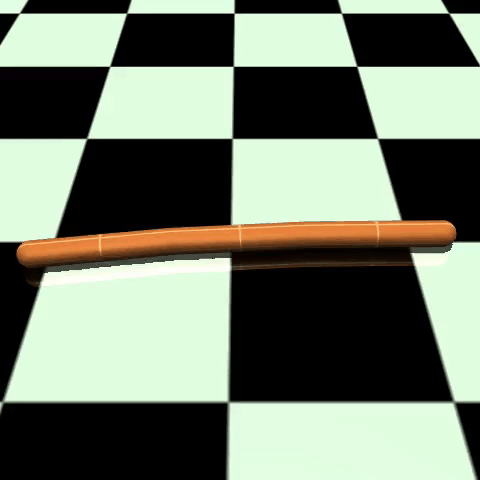

In [12]:
# Visualize the BC agent's behavior
gym_simulation("Swimmer-v5", bc_agent, max_t=150)

## Conclusion

In this notebook, we've successfully trained a policy using Behavioral Cloning on a continuous
control task, learning from a real expert. We saw that even this simple method can achieve
impressive performance, closely mimicking the expert.

However, we also saw that BC is often not perfect. It's just the first step. The field of Imitation
Learning offers a rich set of tools for learning from expert data, each with its own trade-offs.
Here are the key paradigms to be aware of:

- **Behavioral Cloning (BC):** The simplest approach, treating imitation as a supervised learning
  problem. It's easy to implement but can be brittle due to the **covariate shift** problem, where
  small errors lead the agent into unfamiliar states.

- **Dataset Aggregation (DAgger):** An interactive algorithm that directly addresses covariate
  shift. It works by iteratively running the agent's policy, asking an expert for corrections, and
  aggregating this new data to retrain the policy.

- **Inverse Reinforcement Learning (IRL):** A more robust method that aims to learn the expert's
  underlying **reward function** rather than just copying actions. By understanding the expert's
  "intent," the agent can generalize better to new situations.

- **Generative Adversarial Imitation Learning (GAIL):** A modern, powerful technique that uses a
  GAN-like setup. A generator (the policy) tries to create expert-like behavior to "fool" a
  discriminator, which learns to distinguish between agent and expert data.

I hope this gives you a solid, practical foundation for your exploration of Imitation Learning!
